In [1]:
# --- Імпорт бібліотек ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Дозволяє відображати графіки прямо в ноутбуці
%matplotlib inline

# Імпортуємо необхідні модулі для трансформації даних, побудови моделей та оцінки якості
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pickle
import os

## **1. Аналіз Даних (EDA)**

In [2]:
#завантаження датасет
dataset_url = "https://drive.google.com/uc?export=download&id=1rrowhashf4ibJkV-cfZG5Fl1o_UrL8bB"

In [3]:
df = pd.read_csv(dataset_url)
df.head()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,18,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,27,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,34,0,0,6.39,0,NaN,0,0.0,0.0,0,1


In [4]:
# перевіряємо загальну інформацію
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72274 entries, 0 to 72273
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           72274 non-null  int64  
 1   is_tv_subscriber             72274 non-null  int64  
 2   is_movie_package_subscriber  72274 non-null  int64  
 3   subscription_age             72274 non-null  float64
 4   bill_avg                     72274 non-null  int64  
 5   reamining_contract           50702 non-null  float64
 6   service_failure_count        72274 non-null  int64  
 7   download_avg                 71893 non-null  float64
 8   upload_avg                   71893 non-null  float64
 9   download_over_limit          72274 non-null  int64  
 10  churn                        72274 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 6.1 MB


In [5]:
# статистичний опис числових ознак
df.describe()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
count,7.227400e+04,72274.000000,72274.000000,72274.000000,72274.000000,50702.000000,72274.000000,71893.000000,71893.000000,72274.000000,72274.000000
mean,8.463182e+05,0.815259,0.334629,2.450051,18.942483,0.716039,0.274234,43.689911,4.192076,0.207613,0.554141
std,4.891022e+05,0.388090,0.471864,2.034990,13.215386,0.697102,0.816621,63.405963,9.818896,0.997123,0.497064
min,1.500000e+01,0.000000,0.000000,-0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.222165e+05,1.000000,0.000000,0.930000,13.000000,0.000000,0.000000,6.700000,0.500000,0.000000,0.000000
50%,8.477840e+05,1.000000,0.000000,1.980000,19.000000,0.570000,0.000000,27.800000,2.100000,0.000000,1.000000
75%,1.269562e+06,1.000000,1.000000,3.300000,22.000000,1.310000,0.000000,60.500000,4.800000,0.000000,1.000000
max,1.689744e+06,1.000000,1.000000,12.800000,406.000000,2.920000,19.000000,4415.200000,453.300000,7.000000,1.000000


In [6]:
# перевірка пропусків
df.isnull().sum()

,0
id,0
is_tv_subscriber,0
is_movie_package_subscriber,0
subscription_age,0
bill_avg,0
reamining_contract,21572
service_failure_count,0
download_avg,381
upload_avg,381
download_over_limit,0


In [7]:
# перевірка дублікатів
df.duplicated().sum()

np.int64(0)

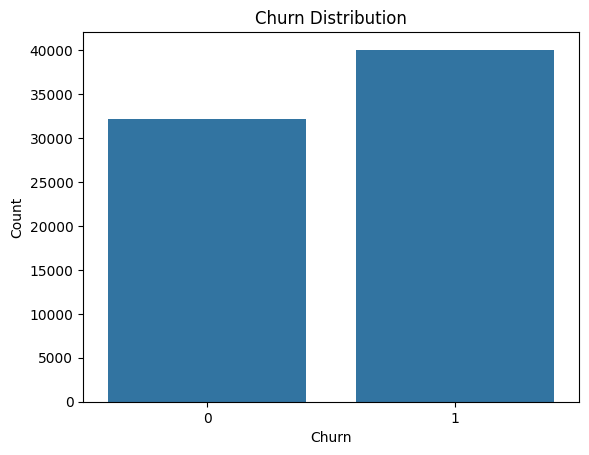

In [8]:
# розподіленя цільової перемінної
sns.countplot(data = df, x = 'churn')
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

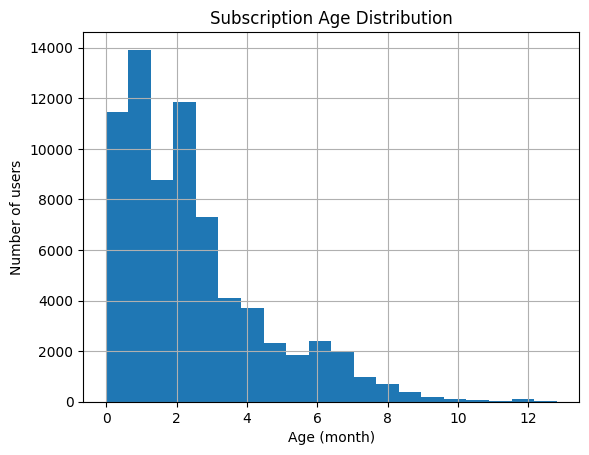

In [9]:
# термін "життя" підписки
df['subscription_age'].hist(bins=20)
plt.title('Subscription Age Distribution')
plt.xlabel('Age (month)')
plt.ylabel('Number of users')
plt.show()

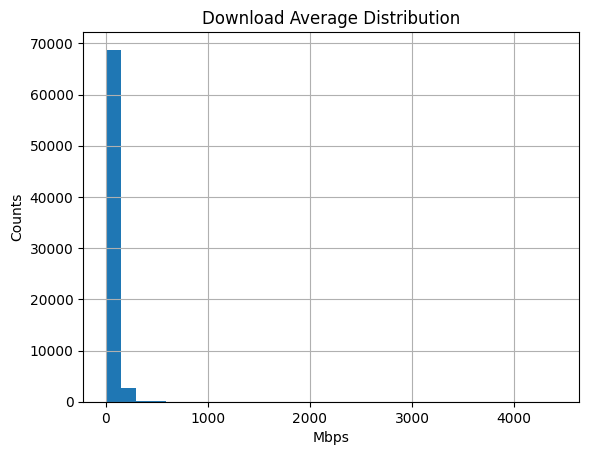

In [10]:
# розподілення середньої швидкості завантаження
df['download_avg'].hist(bins=30)
plt.title('Download Average Distribution')
plt.xlabel('Mbps')
plt.ylabel('Counts')
plt.show()

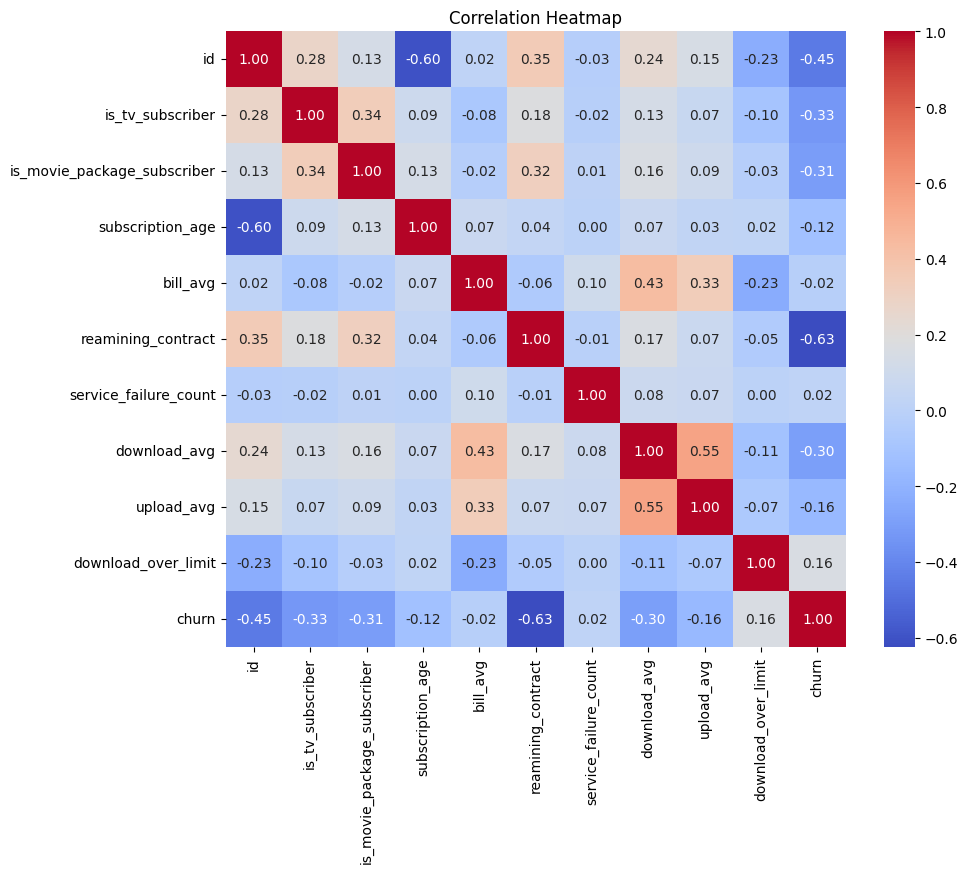

In [11]:
# кореляція
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [12]:
# очістка даних
# видалим колонку id - номер клієнта (не несе функціонального змісту)
# обробимо subscription_age < 0 - помилка в даних(виправим)
# заповним пропуски в reaming_contract - багато пропусків заповним медіаной
# заповним пропуски в download_avg nf upload_avg
# добавимо колонку-флаг contract_unknown - буде корисно"пропущений контракт чи ні"

In [13]:
# видаляємо id
if 'id' in df.columns:
    df.drop('id', axis=1, inplace=True)

# виправляємо мінусові значення терміну підписки
df['subscription_age'] = df['subscription_age'].apply(lambda x: max(x, 0))

# флаг, де відсутсвує контракт (1 - якщо пропущений)
df['contract_unknown'] = df['reamining_contract'].isnull().astype(int)

# заповнюємо пропуски
# спочатку обчіслюємо мудіану
median_contract = df['reamining_contract'].median()
# остаток по контракту - медіаною
df['reamining_contract'] = df['reamining_contract'].fillna(median_contract)

# швидкості - нулями(інтернет відсутній)
df['download_avg'] = df['download_avg'].fillna(0)
df['upload_avg'] = df['upload_avg'].fillna(0)

In [14]:
# агрегація по ключовим признакам
# доля віддотку по підписці на ТБ
# is_tv_subscriber:
# 0 — клієнт НЕ підписаний на ТБ
# 1 — клієнт підписаний на ТБ
# churn:
# 0 — клієнт залишився
# 1 — клієнт пішов
tv_churn = df.groupby('is_tv_subscriber')['churn'].value_counts(normalize=True).unstack()
print(tv_churn)

churn                    0         1
is_tv_subscriber                    
0                 0.103805  0.896195
1                 0.523370  0.476630


Клієнти без ТВ (0) — мають ~89% вірогідності відтоку.
З підпискою (1) — лише ~47%. Підписка на ТБ — знижує ризик відтоку.

In [15]:
# доля відтоку по підписці на фільми
# is_movie_package_subscriber:
# 0 — НЕ підписаний на фільми
# 1 — підписаний на фільми

# churn:
# 0 — залишився
# 1 — пішов
movie_churn = df.groupby('is_movie_package_subscriber')['churn'].value_counts(normalize=True).unstack()
print('Churn по is_movie_package_subscriber:')
print(movie_churn)

Churn по is_movie_package_subscriber:
churn                               0         1
is_movie_package_subscriber                    
0                            0.337582  0.662418
1                            0.661154  0.338846


Підписка на фільми також знижує вірогідність відтоку майже вдвічі.

In [16]:
# середній рахунок по cgurn(відписався чи ні)
# churn:
# 0 — залишився
# 1 — пішов
df.groupby('churn')['bill_avg'].mean()

,bill_avg
churn,
0,19.252731
1,18.692859


Клієнти, які залишаються, платять трохи більше в середньому.

In [17]:
# середній тривалість підписки
# churn:
# 0 — залишився
# 1 — пішов
df.groupby('churn')['subscription_age'].mean()

,subscription_age
churn,
0,2.727828
1,2.226554


Чим довше користуються — тим менше шанс відтоку

In [18]:
# остаток контракту в залежності від churm
# churn:
# 0 — залишився
# 1 — пішов
df.groupby('churn')['reamining_contract'].mean()

,reamining_contract
churn,
0,1.043854
1,0.373620


Чим менше залишилось по контракту — тим вища ймовірність відтоку.
Тобто коли договір майже завершився — клієнти частіше йдуть.

Висновки:
Файл internet_service_churn.csv:
- розмір: 72 274 записів, 11 колонок;
- переважно числові типи: int64, float64;
- багато бінарних ознак (0/1): is_tv_subscriber, is_movie_package_subscriber, churn;
Пропуски:
- reamining_contract: 21 572 пропусків - заповнено медіанним значенням;
- download_avg, upload_avg: 381 пропуск - заповнено нулями (відсутній інтернет);
- створено нову фічу - contract_unknown = 1, якщо значення reamining_contract було пропущене;
Дублі
Дублікатів не виявлено (df.duplicated().sum() == 0).
Аномалії
- виявлено від’ємні значення у subscription_age - замінено на 0;
- bill_avg має максимум 406 - розглянуто як допустиме значення (без аномалій).
Кореляційна матриця
Створено теплову карту через sns.heatmap()
Сильна кореляція між: download_avg - upload_avg
Інших сильних залежностей немає.
Агрегації (churn analysis)
Підписка на ТБ:
Без підписки — 89% пішли
З підпискою — лише 47%
Підписка на фільми:
Без підписки — 66% пішли
З підпискою — лише 34%
Середній чек:
Ті, хто залишилися — платили більше
subscription_age:
Вища у тих, хто залишився
Залишок контракту:
Довший у тих, хто залишився.
Висновки:
Є кілька важливих чинників, що мають вплив на відтік клієнтів:
- наявність підписки на ТВ/кіно;
- тривалість користування послугою (subscription_age);
- залишок контракту (reamining_contract)

Дані очищені та готові до моделювання

## **2. Попередня Обробка Даних**

In [19]:
# 1. Відокремлюємо цільову змінну (y) та ознаки (X)
y = df['churn']                     # Цільова змінна - чи пішов клієнт
X = df.drop('churn', axis=1)        # Всі інші стовпці - ознаки

In [20]:
# 2. Перетворюємо цільову змінну з текстової у числову (0 або 1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)    # Наприклад: 'Yes' -> 1, 'No' -> 0

In [21]:
# 3. Визначаємо, які колонки є числовими, а які — категоріальними
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [22]:
# --- Підготовка pipeline з StandardScaler ---
# Масштабуємо числові ознаки до стандартного нормального розподілу (середнє = 0, стандартне відхилення = 1)
# Також кодуємо категоріальні змінні в one-hot формат
ct_standard = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),                              # масштабуємо числові
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)     # one-hot для категоріальних
])
X_standard = ct_standard.fit_transform(X)  # Застосовуємо трансформації до всіх даних

In [23]:
# --- Підготовка pipeline з MinMaxScaler ---
# Масштабуємо числові ознаки у діапазон [0, 1]
ct_minmax = ColumnTransformer([
    ('num', MinMaxScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])
X_minmax = ct_minmax.fit_transform(X)

In [24]:
# --- Розбиваємо дані на тренувальний і тестовий набори (80/20) ---
# Для StandardScaler
X_train_std, X_test_std, y_train, y_test = train_test_split(X_standard, y_encoded, test_size=0.2, random_state=42)

# Для MinMaxScaler (y_train і y_test ті ж самі, щоб порівняння було справедливим)
X_train_min, X_test_min, _, _ = train_test_split(X_minmax, y_encoded, test_size=0.2, random_state=42)

In [25]:
# --- Навчання моделі LogisticRegression з даними, масштабованими StandardScaler ---
model_std = LogisticRegression(max_iter=1000)  # Збільшуємо кількість ітерацій для надійності
model_std.fit(X_train_std, y_train)            # Навчаємо модель
y_pred_std = model_std.predict(X_test_std)     # Робимо передбачення
acc_std = accuracy_score(y_test, y_pred_std)   # Обчислюємо точність

In [26]:
# --- Навчання моделі LogisticRegression з даними, масштабованими MinMaxScaler ---
model_min = LogisticRegression(max_iter=1000)
model_min.fit(X_train_min, y_train)
y_pred_min = model_min.predict(X_test_min)
acc_min = accuracy_score(y_test, y_pred_min)

In [27]:
# --- Виводимо результати ---
print(f"Точність LogisticRegression з StandardScaler: {acc_std:.4f}")
print(f"Точність LogisticRegression з MinMaxScaler: {acc_min:.4f}")

Точність LogisticRegression з StandardScaler: 0.8767
Точність LogisticRegression з MinMaxScaler: 0.8754


In [28]:
# Важливість ознак для стандартних даних
coefficients = model_std.coef_[0]
feature_names = X.columns
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': np.abs(coefficients)
}).sort_values(by='Importance', ascending=False)
print("\nТоп важливих ознак:\n", feature_importance.head(10))


Топ важливих ознак:
                        Feature  Coefficient  Importance
4           reamining_contract    -1.664902    1.664902
9             contract_unknown     1.248786    1.248786
6                 download_avg    -0.629274    0.629274
2             subscription_age    -0.587683    0.587683
0             is_tv_subscriber    -0.579408    0.579408
8          download_over_limit     0.393505    0.393505
5        service_failure_count     0.126475    0.126475
3                     bill_avg    -0.080879    0.080879
1  is_movie_package_subscriber    -0.015902    0.015902
7                   upload_avg     0.002675    0.002675


In [29]:
# SelectKBest — обираємо 10 найважливіших ознак
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_std, y_train)
X_test_selected = selector.transform(X_test_std)
selected_feature_names = feature_names[selector.get_support()]
print("\nОбрані ознаки за SelectKBest:\n", selected_feature_names)


Обрані ознаки за SelectKBest:
 Index(['is_tv_subscriber', 'is_movie_package_subscriber', 'subscription_age',
       'bill_avg', 'reamining_contract', 'service_failure_count',
       'download_avg', 'upload_avg', 'download_over_limit',
       'contract_unknown'],
      dtype='object')


In [30]:
# Модель на скорочених ознаках
model_selected = LogisticRegression(max_iter=1000)
model_selected.fit(X_train_selected, y_train)
y_pred_selected = model_selected.predict(X_test_selected)
acc_selected = accuracy_score(y_test, y_pred_selected)
print(f"\nТочність LogisticRegression з відібраними ознаками: {acc_selected:.4f}")


Точність LogisticRegression з відібраними ознаками: 0.8767


На цьому етапі успішно виконана попередня обробка даних, що включала наступні кроки:
- Енкодинг категоріальних ознак:
Для ознак, що містять текстові значення (тип підписки тощо), застосовано One-Hot Encoding, щоб перетворити їх у числовий формат, придатний для моделювання.
Цільову змінну (тип відтоку) перетворено за допомогою Label Encoding, оскільки вона має лише два категоріальні значення.
- Масштабування числових ознак:
Проведено порівняння між StandardScaler та MinMaxScaler, оскільки числові ознаки мали різні діапазони значень.
Найкращий результат показала модель з StandardScaler, точність склала 0.8767, що трохи вище за результат з MinMaxScaler (0.8756).
- Відбір ознак:
Було застосовано SelectKBest, щоб оцінити, чи можна зменшити кількість ознак без втрати точності.
Після відбору ознак точність моделі залишилася на рівні 0.8767, що свідчить про те, що деякі ознаки можна відкинути без втрати якості моделі.

Для подальшої роботи з моделями рекомендовано використовувати X_train_std, X_test_std, y_train, y_test - тобто дані після масштабування через StandardScaler.

## **3. Розробка Моделі**

In [31]:

#  1. Створюємо моделі
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier( eval_metric='logloss', random_state=42)
}

Чому саме ці моделі

| Модель                  | Пояснення                                                                              |
| ----------------------- | -------------------------------------------------------------------------------------- |
| **Logistic Regression** | Базова інтерпретована модель для класифікації, швидка, легка в аналізі                 |
| **Random Forest**       | Міцна до шуму, добре працює на табличних даних, автоматично враховує нелінійності      |
| **XGBoost**             | Потужна модель градієнтного бустингу, часто дає найкращі результати на табличних даних |



In [32]:
# 2. Навчаємо та оцінюємо кожну модель
for name, model in models.items():
    print(f"\n {name}")
    # Крос-валідація по F1
    f1_cv = cross_val_score(model, X_train_std, y_train, cv=5, scoring='f1').mean()

    # Навчання
    model.fit(X_train_std, y_train)

    # Прогноз
    y_pred = model.predict(X_test_std)

    # Метрики
    print("Cross-val F1 (train):", round(f1_cv, 4))
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
    print("Precision:", round(precision_score(y_test, y_pred), 4))
    print("Recall:", round(recall_score(y_test, y_pred), 4))
    print("F1 Score:", round(f1_score(y_test, y_pred), 4))


 Logistic Regression
Cross-val F1 (train): 0.8924
Accuracy: 0.8767
Precision: 0.8681
Recall: 0.9133
F1 Score: 0.8901

 Random Forest
Cross-val F1 (train): 0.9451
Accuracy: 0.9413
Precision: 0.9539
Recall: 0.938
F1 Score: 0.9459

 XGBoost
Cross-val F1 (train): 0.9474
Accuracy: 0.9428
Precision: 0.9543
Recall: 0.9404
F1 Score: 0.9473


In [33]:

#  3. Зберігаємо найкращу модель — XGBoost
best_model = XGBClassifier(eval_metric='logloss', random_state=42)
best_model.fit(X_train_std, y_train)

# Створення теки, якщо потрібно
import os
os.makedirs("models", exist_ok=True)

with open("models/best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

###  Висновки:

* XGBoost показала найкращі результати за всіма
метриками: точність, precision, recall, F1.
*  Random Forest — майже такий самий результат, але
трохи програє у recall.

* Logistic Regression показує нижчі результати, але є найпростіша в інтерпретації.

**Обрана модель**: XGBoost
 Найвища узагальнююча здатність (train F1 ≈ test F1), хороша точність та recall.

